In [1]:
import matplotlib.pyplot as plt
import numpy as np

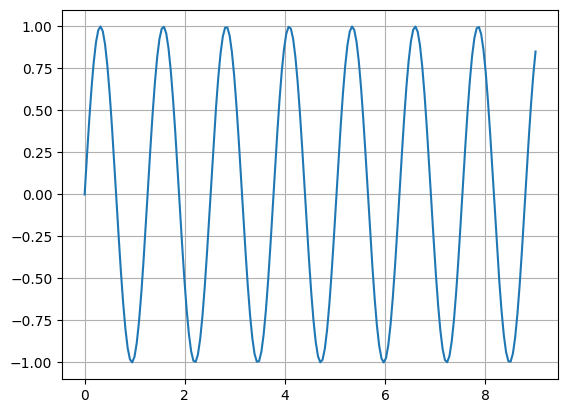

In [19]:
x = np.linspace(0, 9, 200)
y = np.sin(5*x)
plt.plot(x,y)
plt.grid(True)
plt.show()

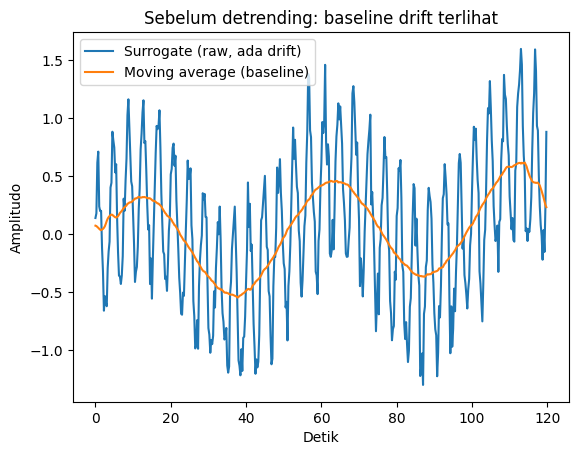

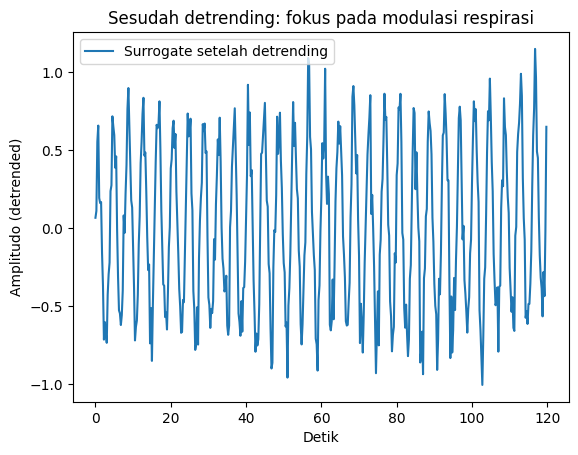

    Epoch  RR_true     RR_raw    RR_EWMA  RR_StepLimited
0       0     15.0  15.267696  15.267696       15.267696
1       1     15.0  16.719857  15.703344       15.703344
2       2     15.0  15.109824  15.525288       15.525288
3       3     15.0  15.696933  15.576782       15.576782
4       4     15.0  14.931860  15.383305       15.383305
5       5     15.0  20.795511  17.006967       17.006967
6       6     15.0  14.064621  16.124263       16.124263
7       7     15.0  15.516362  15.941893       15.941893
8       8     15.0  13.978155  15.352771       15.352771
9       9     15.0  15.798702  15.486551       15.486551
10     10     15.0  16.302344  15.731289       15.731289
11     11     15.0  15.439838  15.643853       15.643853
12     12     15.0   9.656502  13.847648       13.847648
13     13     15.0  22.544759  16.456781       16.456781
14     14     15.0  14.629592  15.908624       15.908624
15     15     15.0  16.122657  15.972834       15.972834
16     16     15.0  12.802313  

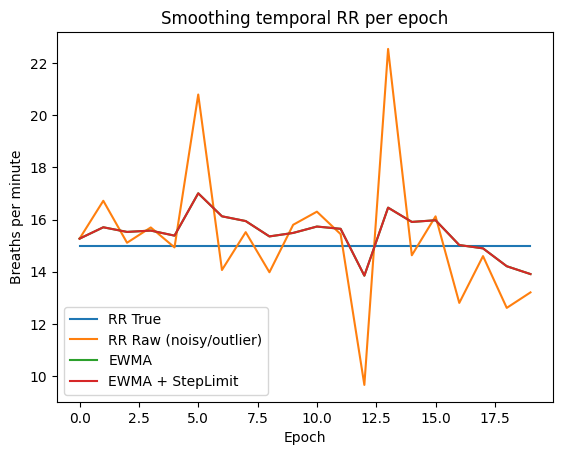

In [1]:
# Re-run in one cell (state was reset)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)

# (1) Detrending surrogate
fs = 4.0
T  = 120.0
t  = np.arange(int(fs*T))/fs
f_rr = 0.25
resp = 0.7*np.sin(2*np.pi*f_rr*t + 0.4)
drift = 0.003*(t - t.mean()) + 0.5*np.sin(2*np.pi*0.02*t)
noise = rng.normal(0, 0.15, size=t.shape)
surrogate_raw = resp + drift + noise

win = 48  # ~12 s
ma = np.convolve(surrogate_raw, np.ones(win)/win, mode="same")
surrogate_detr = surrogate_raw - ma

plt.figure()
plt.plot(t, surrogate_raw, label="Surrogate (raw, ada drift)")
plt.plot(t, ma, label="Moving average (baseline)")
plt.title("Sebelum detrending: baseline drift terlihat")
plt.xlabel("Detik"); plt.ylabel("Amplitudo"); plt.legend()
plt.show()

plt.figure()
plt.plot(t, surrogate_detr, label="Surrogate setelah detrending")
plt.title("Sesudah detrending: fokus pada modulasi respirasi")
plt.xlabel("Detik"); plt.ylabel("Amplitudo (detrended)"); plt.legend()
plt.show()

# (2) Smoothing temporal RR
n_epoch = 20
rr_true = np.full(n_epoch, 15.0)
rr_raw = rr_true + rng.normal(0, 1.2, size=n_epoch)
outlier_idx = [5, 12, 13]
rr_raw[outlier_idx[0]] += 6.0
rr_raw[outlier_idx[1]] -= 5.0
rr_raw[outlier_idx[2]] += 7.0

alpha = 0.3
rr_ewma = np.zeros_like(rr_raw)
rr_ewma[0] = rr_raw[0]
for k in range(1, n_epoch):
    rr_ewma[k] = alpha*rr_raw[k] + (1-alpha)*rr_ewma[k-1]

step_limit = 3.0
rr_step = np.zeros_like(rr_raw)
rr_step[0] = rr_raw[0]
for k in range(1, n_epoch):
    proposal = alpha*rr_raw[k] + (1-alpha)*rr_step[k-1]
    delta = proposal - rr_step[k-1]
    if np.abs(delta) > step_limit:
        proposal = rr_step[k-1] + np.sign(delta)*step_limit
    rr_step[k] = proposal

mae_raw  = float(np.mean(np.abs(rr_raw  - rr_true)))
mae_ewma = float(np.mean(np.abs(rr_ewma - rr_true)))
mae_step = float(np.mean(np.abs(rr_step - rr_true)))

df_rr = pd.DataFrame({
    "Epoch": np.arange(n_epoch),
    "RR_true": rr_true,
    "RR_raw": rr_raw,
    "RR_EWMA": rr_ewma,
    "RR_StepLimited": rr_step
})
print(df_rr)

df_mae = pd.DataFrame([
    {"Metode": "Raw (tanpa smoothing)", "MAE_bpm": mae_raw},
    {"Metode": "EWMA", "MAE_bpm": mae_ewma},
    {"Metode": "EWMA + step limit 3 bpm", "MAE_bpm": mae_step},
])
print(df_mae)

plt.figure()
plt.plot(df_rr["Epoch"], df_rr["RR_true"], label="RR True")
plt.plot(df_rr["Epoch"], df_rr["RR_raw"], label="RR Raw (noisy/outlier)")
plt.plot(df_rr["Epoch"], df_rr["RR_EWMA"], label="EWMA")
plt.plot(df_rr["Epoch"], df_rr["RR_StepLimited"], label="EWMA + StepLimit")
plt.title("Smoothing temporal RR per epoch")
plt.xlabel("Epoch"); plt.ylabel("Breaths per minute"); plt.legend()
plt.show()